**Exercise 2 - XGBoost and SHAP for drought impact analysis**

Hi

Today we use a dataset of empirical yield gaps per Landkreis in Brandenburg
...

Predictive features are relative area > | < threshold of
- SPEI
- SMI
- ...


In addition to the Python modules that you already know from last session, we now also need scikit-learn, xgboost, and SHAP
...


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
import shap

pd.set_option('display.max_colwidth', 255)
os.listdir("data")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


['brandenburg_landkreise_id_25833.gpkg',
 'subset_cottbus.gpkg',
 'subset_random.csv',
 'subset_random.gpkg',
 'yield_gap_vs_thresholds.csv']

In [2]:
data = pd.read_csv("data/subset_random.csv").dropna()
data.columns


Index(['Unnamed: 0', 'crop', 'azl', 'lbg', 'twi', 'nfk', 'area_iacs',
       'SMI_magnitude', 'lst', 'ndvi', 'year', 'lstndvi', 'lstndvi_anom',
       'SPEI_magnitude'],
      dtype='object')

In [3]:
data = data[["crop", "azl", "twi", "nfk", "SPEI_magnitude", "SMI_magnitude", "lstndvi_anom"]]

# convert crop type to binary columns (one-hot encoding)
data = pd.get_dummies(data, columns=["crop"])
crop_cols = [col for col in data.columns if col.startswith('crop_')]

data.head()

,azl,twi,nfk,SPEI_magnitude,SMI_magnitude,lstndvi_anom,crop_grain_maize,crop_lupines,crop_oat,crop_peas,crop_potatoes,crop_rye,crop_sugarbeet,crop_summer_canola,crop_sunflower,crop_triticale,crop_winter_barley,crop_winter_canola,crop_winter_wheat
0,21.53,12.00,219.78,-0.72,0.0,-0.18,0,0,0,0,0,1,0,0,0,0,0,0,0
1,23.78,9.91,179.18,-0.72,0.0,-0.17,0,0,0,0,0,1,0,0,0,0,0,0,0
2,41.37,12.19,122.76,-0.89,0.0,-0.39,1,0,0,0,0,0,0,0,0,0,0,0,0
3,38.76,13.66,174.54,-0.72,0.0,0.26,0,0,0,0,0,0,0,0,0,0,0,0,1
4,27.52,12.37,99.64,-0.56,0.0,0.02,0,0,0,0,0,1,0,0,0,0,0,0,0


### Feature selection

In [4]:
y = data["lstndvi_anom"]
X = data.drop("lstndvi_anom", axis="columns")

print(X.shape, y.shape)

# convert to numpy for xgb - and revert this later to get feature names in SHAP plots
Xnp = X.to_numpy()
ynp = y.to_numpy()

(9190, 18) (9190,)


### Nested cross-validataion

![nested cross validataion](nested_cv.png)

**Typically these subsets are called 'training' and 'test', but for the sake of clarity let's call them 'holdout' and 'parametrization' here**

In [5]:
# the function train_test_split returns 4 objects. These can be stored by assigning 4 variables
X_parametrization, X_holdout, y_parametrization, y_holdout = train_test_split(Xnp, ynp, test_size=0.3)

# change the "test_size" parameter and check the dimensionality of the parametrizations (rows, columns)
print(X_parametrization.shape, y_parametrization.shape, X_holdout.shape, y_holdout.shape)

(6433, 18) (6433,) (2757, 18) (2757,)


In [6]:
algorithm = xgb.XGBRegressor(booster='gbtree', tree_method='hist')
algorithm

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

**One very important thing that is often overlooked by ML-beginners and even intermediate level articles & tutorials, is the algorithm-internal objective function.**

ML models are crated from algorithms by optimizing a function in which performance is measured by a defined metric. That means the structure of the resulting model is adjusted to perform as good as possible on this very metric.

In the case of XGBoostRegressor, the default metric is the squared error

In [7]:
algorithm.objective

'reg:squarederror'

When evaluating different models, it might make sense to compare them by a differnt metric that is related to the specifics of the intended application case. However, keep in mind that you might then be looking at metrics on which the model has not been optimized!

In [8]:
# define a set of parameter values to check
xgb_parameters = {
    'n_estimators':[100],
    'max_depth':[4,6,8,10],
    'gamma':[0, 0.1, 1],
    'subsample':[0.8],
    'colsample_bytree':[0.8],
    'learning_rate':[0.1]
    }

# parametrization internally using another data split, controlled by the parameter cv
gs = GridSearchCV(algorithm, param_grid=xgb_parameters, cv=5, scoring="neg_mean_squared_error")
gs_results = gs.fit(X_parametrization, y_parametrization)

# print the results in human-readible table format
pd.DataFrame({'rank': gs_results.cv_results_['rank_test_score'],
              'mean': gs_results.cv_results_['mean_test_score'],
              'sd'  : gs_results.cv_results_['std_test_score'],
              'params': gs_results.cv_results_['params']}).sort_values("rank")

,rank,mean,sd,params
0,1,-0.034851,0.002063,"{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}"
4,2,-0.034897,0.002202,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}"
5,3,-0.035273,0.002215,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}"
6,4,-0.035475,0.002199,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}"
7,5,-0.035517,0.002196,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}"
1,6,-0.035771,0.002165,"{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}"
8,7,-0.036671,0.002094,"{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}"
9,7,-0.036671,0.002094,"{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}"
10,7,-0.036671,0.002094,"{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}"
11,7,-0.036671,0.002094,"{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}"


### wrap everything in a function

In [10]:
def train(algorithm, param_grid, X, y, holdout=0.3, repetitions=10, ncv=5):
    """
    wrapper for repeated model fitting with random train test split, including the 
    computation of performance metrics and SHAP values.
    """

    cvscores = []
    holdoutscores = []
    paramlist = []
    estimatorlist = []

    # convert to numpy for xgb - and revert this later to get feature names in SHAP plots
    Xnp = X.to_numpy()
    ynp = y.to_numpy()

    for i in range(repetitions):
        print(i)

        # outer loop for validation
        X_parametrization, X_holdout, y_parametrization, y_holdout = train_test_split(Xnp, ynp, test_size=holdout)
        
        # inner loop to optimize the hyperparameters
        gs = GridSearchCV(algorithm, param_grid=param_grid, cv=ncv, scoring="r2")
        gs_results = gs.fit(X_parametrization, y_parametrization)

        # store the results in separate list
        cvscores.append(gs_results.best_score_)
        paramlist.append(gs_results.best_params_)
        estimatorlist.append(gs_results.best_estimator_)

        # re-train best estimator on full training set and compute score on holdout set
        best_model_of_iteration = gs_results.best_estimator_.fit(X_parametrization, y_parametrization)
        holdoutscores.append(r2_score(y_holdout, best_model_of_iteration.predict(X_holdout)))
    
    # take the best model of all iterations by scored on holdout set, 
    # active early stopping and fit on entire data of the inner loop
    best_model = estimatorlist[np.argmax(holdoutscores)]
    best_model.set_params(early_stopping_rounds=2)
    best_model.fit(X_parametrization, y_parametrization, eval_set=[(X_holdout, y_holdout)])
    n_stop = best_model.get_booster().num_boosted_rounds()
    best_model.set_params(n_estimators = n_stop, early_stopping_rounds=None)
    
    return(best_model, cvscores, holdoutscores, paramlist)

In [11]:
best_model, cvscores, holdoutscores, paramlist = train(algorithm, xgb_parameters, X, y)

0
1
2
3
4
5
6
7
8
9
[0]	validation_0-rmse:0.47665
[1]	validation_0-rmse:0.43725
[2]	validation_0-rmse:0.40259
[3]	validation_0-rmse:0.37240
[4]	validation_0-rmse:0.34539
[5]	validation_0-rmse:0.32198
[6]	validation_0-rmse:0.30186
[7]	validation_0-rmse:0.28447
[8]	validation_0-rmse:0.26974
[9]	validation_0-rmse:0.25686
[10]	validation_0-rmse:0.24615
[11]	validation_0-rmse:0.23711
[12]	validation_0-rmse:0.22940
[13]	validation_0-rmse:0.22276
[14]	validation_0-rmse:0.21755
[15]	validation_0-rmse:0.21296
[16]	validation_0-rmse:0.20929
[17]	validation_0-rmse:0.20610
[18]	validation_0-rmse:0.20362
[19]	validation_0-rmse:0.20147
[20]	validation_0-rmse:0.19964
[21]	validation_0-rmse:0.19823
[22]	validation_0-rmse:0.19712
[23]	validation_0-rmse:0.19618
[24]	validation_0-rmse:0.19532
[25]	validation_0-rmse:0.19460
[26]	validation_0-rmse:0.19395
[27]	validation_0-rmse:0.19352
[28]	validation_0-rmse:0.19319
[29]	validation_0-rmse:0.19275
[30]	validation_0-rmse:0.19240
[31]	validation_0-rmse:0.1921

In [12]:
best_model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=44, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



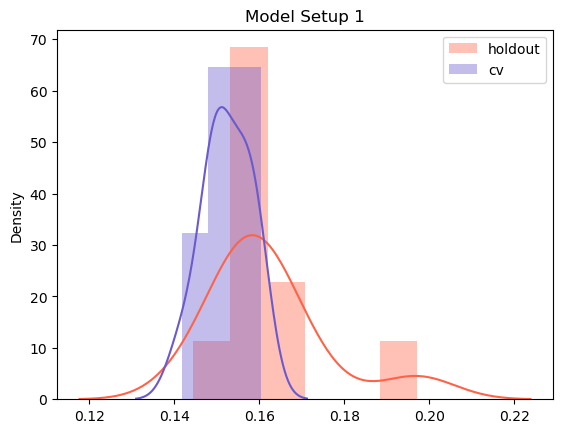

In [13]:
def plotScores(holdoutscores, cvscores, plottitle):
    sns.distplot(holdoutscores, label="holdout", color="tomato") 
    sns.distplot(cvscores, label="cv", color="slateblue")
    plt.legend()
    plt.title(plottitle)

plotScores(holdoutscores, cvscores, "Model Setup 1")

(-0.5, 1.5)

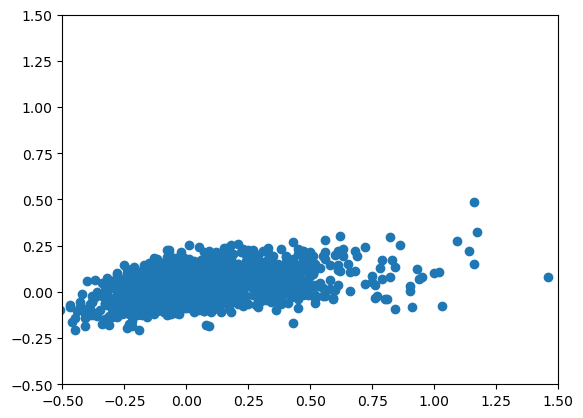

In [27]:
# plot predictions vs observations as scatter plot

plt.scatter(y_holdout, best_model.predict(X_holdout))
plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)

### What exactly is this model doing?

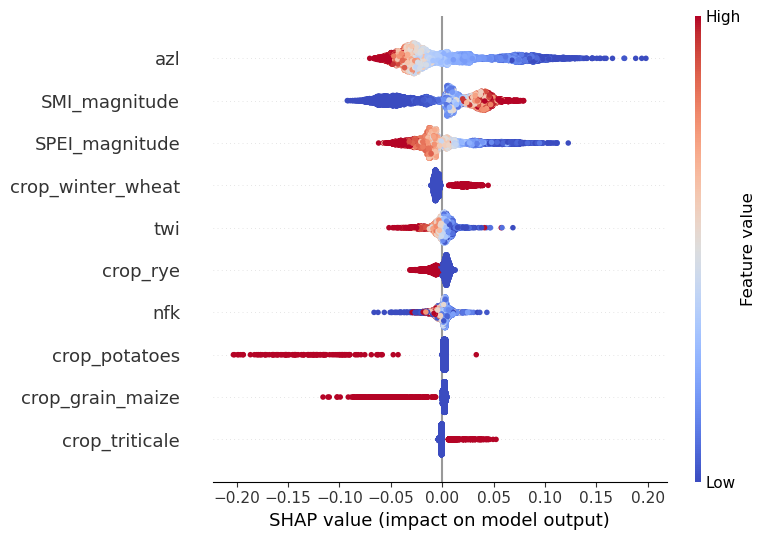

In [15]:
shapvals = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shapvals, X, X.columns, max_display=10, cmap="coolwarm")


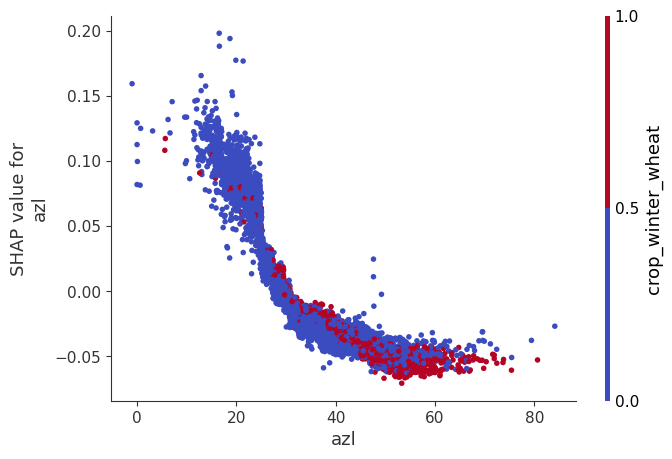

In [23]:
mycmap = colormaps['coolwarm']
shap.dependence_plot("azl", shapvals, X, X.columns, cmap=mycmap,
                     interaction_index="crop_winter_wheat")

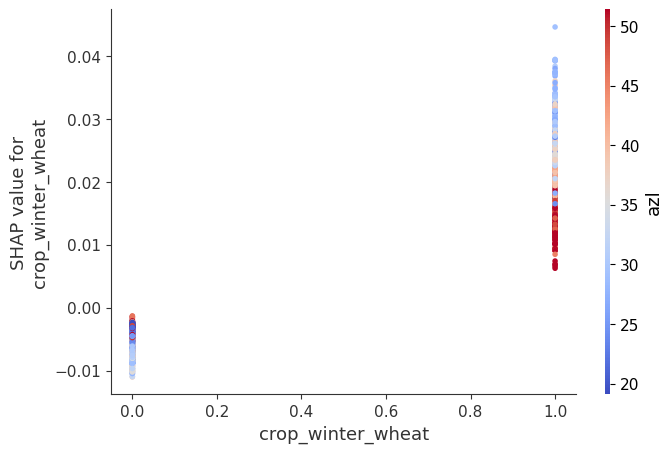

In [21]:
shap.dependence_plot("crop_winter_wheat", shapvals, X, X.columns,
                     cmap=mycmap, interaction_index="azl")

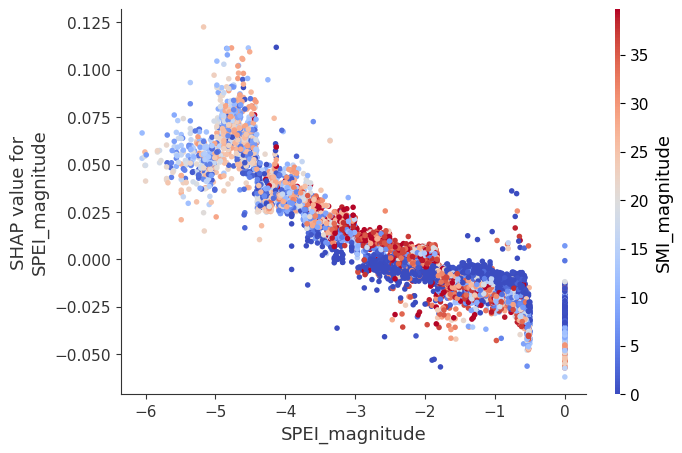

In [17]:
shap.dependence_plot("SPEI_magnitude", shapvals, X, X.columns, cmap=mycmap)

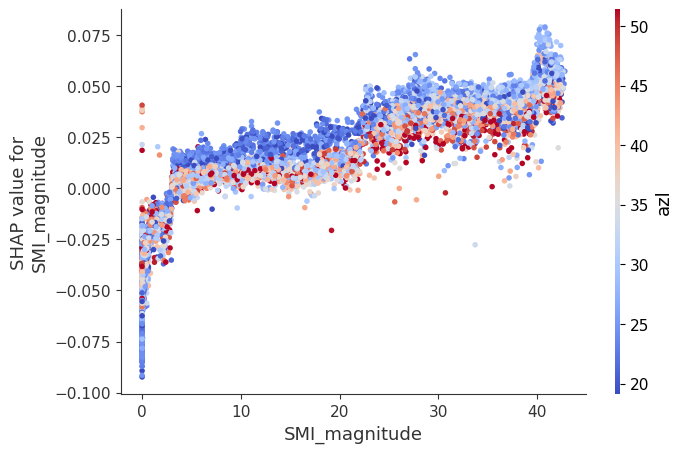

In [22]:
shap.dependence_plot("SMI_magnitude", shapvals, X, X.columns, cmap=mycmap,
                     interaction_index="azl")